# Ryan Tschritter

## Revised Research question/interests

1. **Find the most significantly correlated statistics (and their respective p-values) and assemble them into a scoring model by weight that can predict a players contribution to their team in the next season**

This would have two heatmaps for the correlation and p-values and using a correlation of above 0.5 and a p-value below 0.5 I should be able to then assemble a weighted model that uses higher correlated values to predict a players performance.

2. **Perform the same analysis above but generate a model that shows a player in on the decline**

## Analysis Plan

1. Generate correlation matrix for all columns of data
2. Generate a p-value matrix for the correlation matrix
3. Remove the correlations that have a value below 0.5
4. Remove the p-values above 0.5
6. Create a weighted model using the final correlated statistics for both positive contribution and negative
8. Run the original data though the model and show that it predicts performance corretly

## Analysis Pipeline
---

In [81]:
# Import Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
import sys
import importlib
sys.path.append('..')
from analysis.code import project_functions3 as pf3
importlib.reload(pf3) # Forcing a reload of the function because it was running a old verion in memory

nhlMerged = pf3.load_and_merge3('../data/processed/Data301ProjectData2017.csv', '../data/processed/Data301ProjectData2018.csv')

In [83]:
#Import Cleaned Data
nhl2017 = pd.read_csv('../data/processed/clean2017.csv')
nhl2018 = pd.read_csv('../data/processed/clean2018.csv')

In [84]:
# Import Merged Dataset with sufixes
#nhlMerged = pd.read_csv('../data/processed/merged.csv')

In [85]:
# View the shape of the dataframes (ie. the number of columns and rows)
fstring1 = f"The shape of the 2017 dataframe is {nhl2017.shape}."
fstring2 = f"The shape of the 2018 dataframe is {nhl2018.shape}."
fstring3 = f"The shape of the merged dataframe is {nhlMerged.shape}."
print(fstring1)
print(fstring2)
print(fstring3)

The shape of the 2017 dataframe is (225, 19).
The shape of the 2018 dataframe is (225, 19).
The shape of the merged dataframe is (225, 37).


In [86]:
# Check to make sure the 2017 names match the 2018 names
print(nhl2017['Name'].equals(nhl2018['Name']))
print(nhlMerged['Name'].equals(nhl2018['Name']))

True
True


In [87]:
# Python dictionary for column titles
legend = {
    'Rk':'Rank In List', # The order when the data was exported from the website
    'GP':'Games Played', # The number of games played in the season
    'G':'Goals Scored', # The total number of goals scored in the season
    'A':'Assists', # The number of assists in the season
    'P':'Points', # Goals plus assists equals points
    'PIM':'Penalty Minutes', # Total number of minutes spent in the penalty box
    '+/-':'Plus Minus', # Tracks difference in goals scored when on ice, plus one when a goal is scored, minus one when a opposing team scores
    'TOI':'Average Time on Ice', # The average time on ice per game
    'PPG':'Power-Play Goals', # Number of goals score by a player when team has a power play
    'GWG':'Game-Winning Goals', # The player that scored the final goal of the game (total cumulative)
    'PPP':'Power-Play Points', # Players own power play points, positively correlated with power play goals and power play assists
    'G/GP':'Goals Per Game Played', # Goals per game played accounts for players that haven't played every game
    'A/GP':'Assists Per Game Played', # Assists per game played accounts for players that haven't played every game
    'P/GP':'Points Per Game Played', # Points per game played accounts for players that haven't played every game
    'SHOTS':'Shots On Goal', # Number of attempted shots on goal
    'SH%':'Shot Percentage', # Percent of shots that are goals
    'HITS':'Hits', # Number of body checks performed on the opposing team puck carrier
    'BS':'Blocked Shots' # Number of shots blocked by a player
}

# Exploratory Data Analysis
---

In [88]:
nhl2017.head(3)

,Rk,Name,GP,G,A,P,PIM,+/-,TOI,PPG,GWG,PPP,G/GP,A/GP,P/GP,SHOTS,SH%,HITS,BS
0,185,Aaron Ekblad,82,16,22,38,71,9,23:22,5,4,11,0.195,0.268,0.463,189,8.50%,69,121
1,115,Adam Henrique,81,24,26,50,20,11,17:46,6,8,13,0.296,0.321,0.617,151,15.90%,61,61
2,193,Adrian Kempe,81,16,21,37,49,11,13:19,1,3,5,0.198,0.259,0.457,119,13.50%,91,18


In [89]:
nhlMerged.head(3)

,Name,Rk_2017,GP_2017,G_2017,A_2017,P_2017,PIM_2017,+/-_2017,TOI_2017,PPG_2017,...,PPG_2018,GWG_2018,PPP_2018,G/GP_2018,A/GP_2018,P/GP_2018,SHOTS_2018,SH_2018,HITS_2018,BS_2018
0,Aaron Ekblad,185,82,16,22,38,71,9,1402,5,...,5,1,10,0.159,0.293,0.451,180,7.2,114,88
1,Adam Henrique,115,81,24,26,50,20,11,1066,6,...,8,3,13,0.220,0.293,0.512,122,14.8,78,71
2,Adrian Kempe,193,81,16,21,37,49,11,799,1,...,0,2,4,0.148,0.198,0.346,118,10.2,86,21


In [90]:
# nhlMerged.describe().T
# Hiding output to reduce file length

### Comments about the dataframe describe and analysis pipeline

- Some of the mean statistics for 2017 and 2018 are very close, such as the time on ice (TOI)
- When averages and data is simmilar between seasons like this, other analysis methods such as standard deviation become more important

[Text(0.5, 1.0, '2018 Season'),
 Text(0.5, 0, 'Average Time on Ice (min)'),
 Text(0, 0.5, '')]

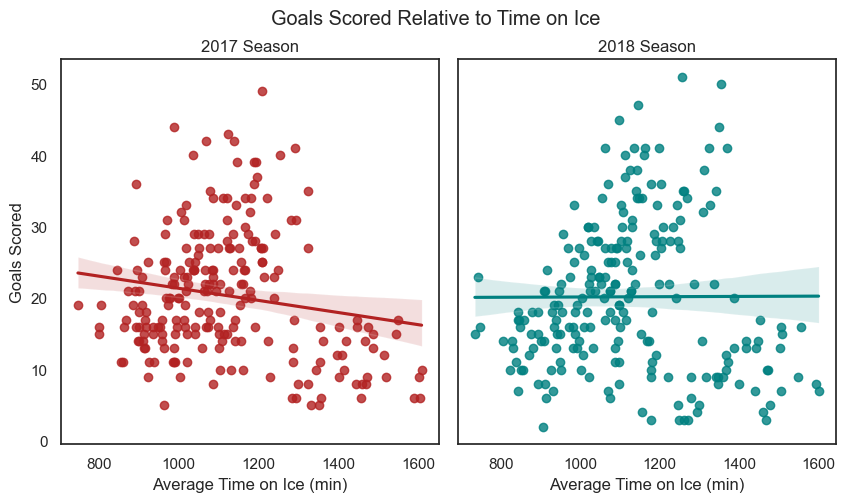

In [91]:
# Plot 1 
sns.set(style = "white")
plot1, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
plot1.suptitle('Goals Scored Relative to Time on Ice')
plot1.subplots_adjust(wspace=0.05)
sns.regplot(ax=axes[0], data = nhlMerged, x = "TOI_2017", y = "G_2017", color = "firebrick")
sns.regplot(ax=axes[1], data = nhlMerged, x = "TOI_2018", y = "G_2018", color = "teal")
axes[0].set(title='2017 Season', xlabel=legend['TOI']+' (min)', ylabel=legend['G'])
axes[1].set(title='2018 Season', xlabel=legend['TOI']+' (min)', ylabel='')

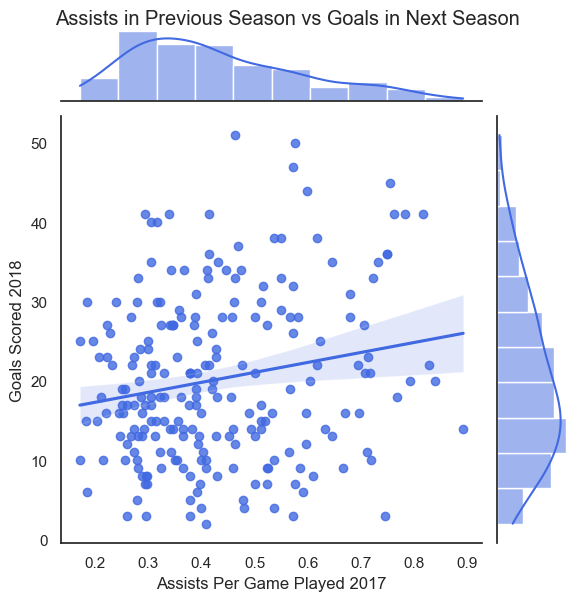

In [92]:
# Plot 2
sns.set(style = "white")
plot2 = sns.jointplot(data=nhlMerged, x = "A/GP_2017", y = "G_2018", kind = "reg", color = "royalblue")
plot2.set_axis_labels(xlabel=legend['A/GP']+' 2017', ylabel=legend['G']+' 2018')
plt.suptitle('Assists in Previous Season vs Goals in Next Season', y=1)
sns.set(font_scale=1)

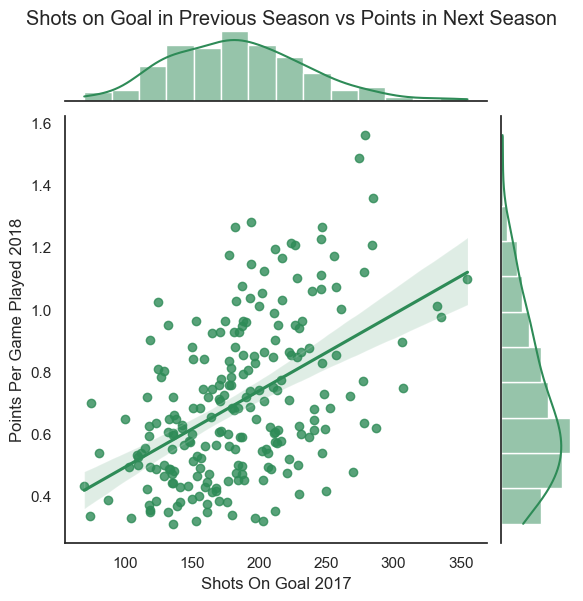

In [93]:
# Plot 3
sns.set(style = "white")
plot3 = sns.jointplot(data=nhlMerged, x = "SHOTS_2017", y = "P/GP_2018", kind = "reg", color = "seagreen")
plot3.set_axis_labels(xlabel=legend['SHOTS']+' 2017', ylabel=legend['P/GP']+' 2018')
plt.suptitle('Shots on Goal in Previous Season vs Points in Next Season', y=1)
sns.set(font_scale=1)

## Some notes about Visualizations

- Was expecting a positive correlation between time on ice and goals score but there wasn't, possibly even a negative correlation
- There is a slight trend with the assists in the previous season leading to more goals in the next season
- The corelation matrix shows how the statistics are corelated with eachother, this partially anwsers one my research questions

# Data Analysis
---

## Revised Research question/interests

1. **Find the most significantly correlated statistics (and their respective p-values) and assemble them into a scoring model by weight that can predict a players contribution to their team in the next season**

This would have two heatmaps for the correlation and p-values and using a correlation of above 0.5 and a p-value below 0.5 I should be able to then assemble a weighted model that uses higher correlated values to predict a players performance.

2. **Perform the same analysis above but generate a model that shows a player in on the decline**

## Analysis Plan

1. Generate correlation matrix for all columns of data
2. Generate a p-value matrix for the correlation matrix
3. Remove the correlations that have a value below 0.5
4. Remove the p-values above 0.5
6. Create a weighted model using the final correlated statistics for both positive contribution and negative
8. Run the original data though the model and show that it predicts performance corretly

In [94]:
# Create a reduced dataframe to find significant correlations
reduced2017 = nhl2017[['GP','P','PIM','TOI','PPP','P/GP','SHOTS']]
reduced2018 = nhl2018[['GP','P','PIM','TOI','PPP','P/GP','SHOTS']]
reducedmerg = nhlMerged[['GP_2017','P_2017','PIM_2017','TOI_2017','PPP_2017','P/GP_2017','SHOTS_2017',
                           'GP_2018','P_2018','PIM_2018','TOI_2018','PPP_2018','P/GP_2018','SHOTS_2018']]

reduced2017 = reduced2017.corr(numeric_only=True).round(3)
reduced2018 = reduced2018.corr(numeric_only=True).round(3)
reducedmerg = reducedmerg.corr(numeric_only=True).round(3)

plotmask2017 = np.triu(np.ones_like(reduced2017, dtype=bool), k=1)
plotmask2018 = np.triu(np.ones_like(reduced2018, dtype=bool), k=1)
plotmaskmerg = np.triu(np.ones_like(reducedmerg, dtype=bool), k=1)

[Text(0.5, 1.0, '2018 Season')]

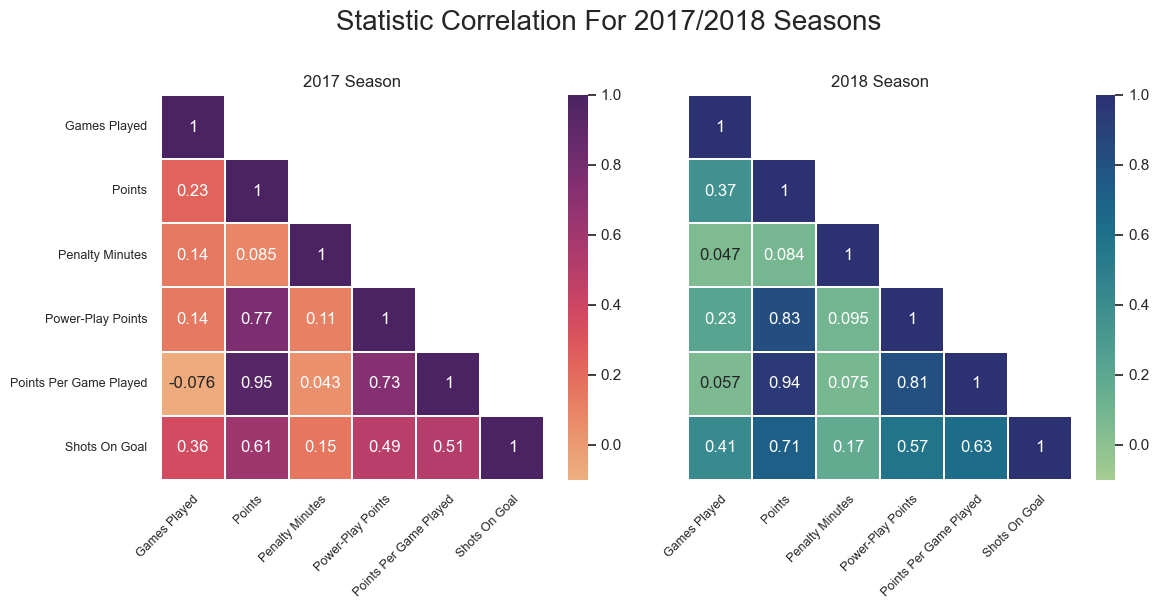

In [167]:
sns.set(style = "white")
plot4, axes = plt.subplots(1, 2, figsize=(13,5), sharey=False)
plot4.suptitle('Statistic Correlation For 2017/2018 Seasons', size=20, x=0.47, y=1.05)
plot4.subplots_adjust(wspace=0.1)

sns.heatmap(ax=axes[0], data=reduced2017, annot=True, linewidths=0.1, mask=plotmask2017, cmap='flare', vmin=-.1, vmax=1)
sns.heatmap(ax=axes[1], data=reduced2018, annot=True, linewidths=0.1, mask=plotmask2018, cmap='crest', vmin=-.1, vmax=1)

tickLabels = []
for i in list(reduced2017.columns):
    tickLabels.append(legend[i])
    

axes[0].set_xticklabels(labels=tickLabels, rotation=45, ha='right', rotation_mode='anchor')
axes[0].set_yticklabels(labels=tickLabels, rotation=0, ha='right', rotation_mode='anchor')
axes[1].set_xticklabels(labels=tickLabels, rotation=45, ha='right', rotation_mode='anchor')
axes[1].set_yticklabels(labels='')
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=9)

axes[0].set(title='2017 Season')
axes[1].set(title='2018 Season')

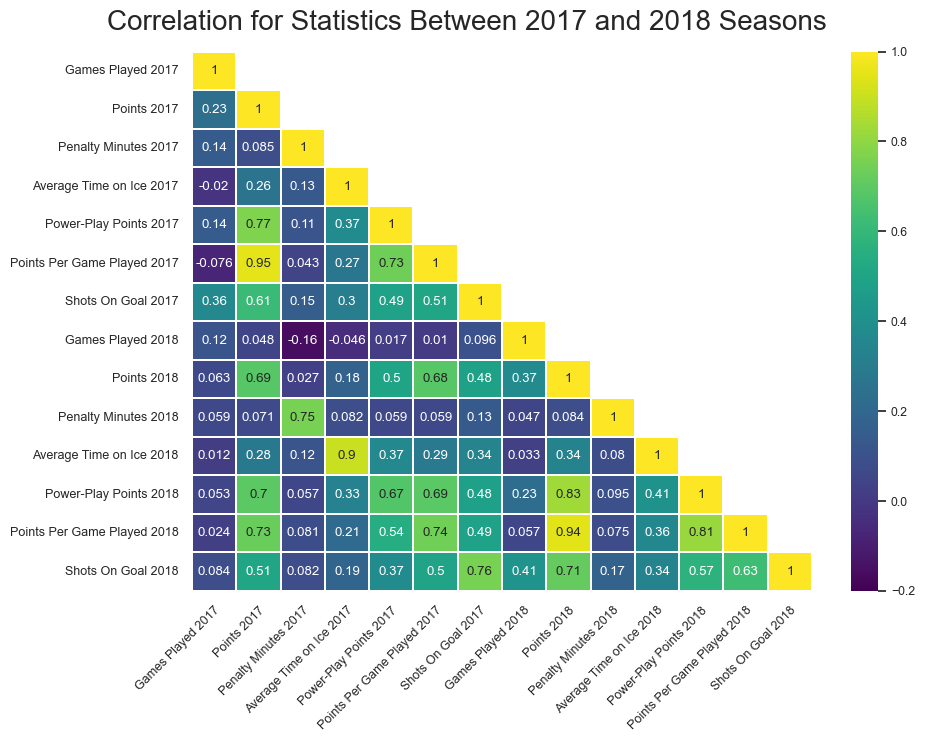

In [166]:
sns.set(style = "white")
plot5, axes = plt.subplots(figsize=(10,7))
plot5.suptitle('Correlation for Statistics Between 2017 and 2018 Seasons', size=20, x=0.4, y=0.94)
sns.set(font_scale=0.8)
sns.heatmap(data=reducedmerg, annot=True, linewidths=0.1, mask=plotmaskmerg, cmap='viridis', vmin=-.2, vmax=1)

tickLabels2 = []
for i in list(reducedmerg.columns): # This is some big brain coding right here...
    splitList = i.split('_', 1)
    tickLabels2.append(legend[splitList[0]]+" "+splitList[1])
    
axes.set_xticklabels(labels=tickLabels2, rotation=45, ha='right', rotation_mode='anchor')
axes.set_yticklabels(labels=tickLabels2, rotation=0, ha='right', rotation_mode='anchor')
axes.tick_params(axis='both', which='major', labelsize=9)

### Analysis of Correlation

From the graphs above we find that there are a few catagories that are significantely corelated such as the points and points per games played for both seasons, the time on ice for both seasons and the power play points with the regular points. All of the mentioned statistics are all inherently correlated meaning they are expected to have simmilar values and not be statisticly significant. 